# Test
## Historisierte Bestände der Gastwirtschaftsbetriebe, 2012-2020
07.01.2022


**Importiere die notwendigen Packages**

In [38]:
#pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly

In [44]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
#from datetime import datetime
import datetime
import geopandas as gpd
import folium 
import time

import plotly.express as px
import plotly.graph_objects as go



Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [45]:
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Datenimport


**Dataset auf INTEG Datenkatalog**: https://data.integ.stadt-zuerich.ch/dataset/int_dwh_sid_wipo_gastwirtschaftsbetriebe

**Dataset auf PROD Datenkatalog**: https://data.stadt-zuerich.ch/dataset/sid_wipo_gastwirtschaftsbetriebe

In [46]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "prod";
print(status)

prod


In [51]:
# Filepath
if status == "prod":
    fp = r"https://data.stadt-zuerich.ch/dataset/sid_wipo_gastwirtschaftsbetriebe/download/historisierte_gastwirtschaftsbetriebe_per_20211231.csv"
else:
    fp = r""
#download from INT-Datacatalog:
# https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bfs_bevreg_todesursache-aggregiert_alter_geschlecht_seit1995_od3120/download/BEV312OD3120.csv
print(fp)

https://data.stadt-zuerich.ch/dataset/sid_wipo_gastwirtschaftsbetriebe/download/historisierte_gastwirtschaftsbetriebe_per_20211231.csv


In [52]:
# Read the data
data2betested = pd.read_csv(
    fp, 
    sep=',',
   #usecols=[0,1,2,3,4,6],
   #names=['stationid','year','month','avgtemp','latitude','longitude','elevation','station','countryid','country'],
   #skiprows=1,
    #parse_dates=True,
    #parse_dates=['GebJ'],    
    #date_parser=lambda x: x.datetime.datetime.strptime(x, '%Y'),
    #index_col="GebJ",
    low_memory=False    
    )

In der Folge ein paar erste Tests:

In [53]:
type(data2betested)

pandas.core.frame.DataFrame

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [54]:
data2betested.head(3)

,Jahr,Betriebsname,StrasseLang,HNr,PLZ,Ort,StatZoneSort,...,Betriebsstatus,XKoord,YKoord,NKoord,EKoord,AnzBetriebe,AnzNachtcafe
0,2021,01 Bar,Köngengasse,2,8001,Zürich,1102,...,Offen,0,0,1247572,2683418,1,1
1,2021,1001 GmbH,Niederdorfstrasse,4,8001,Zürich,1102,...,Offen,0,0,1247478,2683473,1,1
2,2021,169West,Weststrasse,169,8003,Zürich,3405,...,Offen,0,0,1247567,2681517,1,0


In [55]:
data2betested.dtypes

Jahr                int64
Betriebsname       object
StrasseLang        object
HNr                object
PLZ                 int64
Ort                object
StatZoneSort        int64
StatZoneLang       object
QuarSort            int64
QuarLang           object
KreisSort           int64
KreisLang          object
Oeffnungszeit      object
Betriebsart        object
Betriebsstatus     object
XKoord            float64
YKoord            float64
NKoord            float64
EKoord            float64
AnzBetriebe         int64
AnzNachtcafe        int64
dtype: object

### Hilfsspalten hinzufügen (Data enrichment)

1. Erstelle eine Datetime-Objekt der Jahre

In [56]:
data2betested['Jahr_datetime'] = pd.to_datetime(data2betested['Jahr'], format='%Y')


2. Füge Variablen hinzu, welche den ersten, den zweiten und die ersten beiden Buchstaben des Betriebsnamens angeben.

In [57]:
data2betested["FirstLetter"]= data2betested["Betriebsname"].astype(str).str[0]
data2betested["SecondLetter"]= data2betested["Betriebsname"].astype(str).str[1]
data2betested["FirstTwoLetters"]= data2betested["Betriebsname"].str.slice(stop=2)
#data2betested.sort_values(by='AnzPers', ascending=False, inplace=True, na_position='first')


In [58]:
data2betested.head(2)

,Jahr,Betriebsname,StrasseLang,HNr,PLZ,Ort,StatZoneSort,...,EKoord,AnzBetriebe,AnzNachtcafe,Jahr_datetime,FirstLetter,SecondLetter,FirstTwoLetters
0,2021,01 Bar,Köngengasse,2,8001,Zürich,1102,...,2683418,1,1,2021-01-01,0,1,01
1,2021,1001 GmbH,Niederdorfstrasse,4,8001,Zürich,1102,...,2683473,1,1,2021-01-01,1,0,10


Beschreibe einzelne Attribute

In [59]:
data2betested.describe()

,Jahr,PLZ,StatZoneSort,QuarSort,KreisSort,XKoord,YKoord,NKoord,EKoord,AnzBetriebe,AnzNachtcafe
count,21934,21934,21934,21934,21934,21934,21934,21934,21934,21934,21934
mean,2017,8019,5403,54,5,265049,96395,763499,1640804,1,0
std,3,22,3482,35,3,332677,120996,608383,1307447,0,0
min,2012,8001,1101,11,1,0,0,0,0,1,0
25%,2014,8003,2404,24,2,0,0,0,0,1,0
50%,2017,8005,4206,42,4,0,0,1246920,2681421,1,0
75%,2019,8045,8201,82,8,682218,247521,1248117,2683019,1,1
max,2021,8143,12304,123,12,687913,253877,1253877,2687914,1,1


Wie viele Nullwerte gibt es im Datensatz?

In [60]:
data2betested.isnull().sum()

Jahr                   0
Betriebsname           0
StrasseLang            0
HNr                    0
PLZ                    0
Ort                    0
StatZoneSort           0
StatZoneLang           0
QuarSort               0
QuarLang               0
KreisSort              0
KreisLang              0
Oeffnungszeit      15866
Betriebsart            0
Betriebsstatus         1
XKoord                 0
YKoord                 0
NKoord                 0
EKoord                 0
AnzBetriebe            0
AnzNachtcafe           0
Jahr_datetime          0
FirstLetter            0
SecondLetter           0
FirstTwoLetters        0
dtype: int64

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

#### Parsing & Formatting Strings to Dataframes
- [**Cheat Sheet**](https://strftime.org/)
- Python documentation for **strptime**: [string **parse** time, Python 3](https://docs.python.org/3/library/datetime.html#datetime.datetime.strptime)
- Python documentation for strptime/**strftime**: [string **format** time,Python 3](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)



In [69]:
data2betested = data2betested.set_index("Jahr_datetime")
#data2betested = data2betested.drop(columns=["StichtagDatMM"])

KeyError: "None of ['Jahr_datetime'] are in the columns"

In [70]:
#data2betested.info()
data2betested.index.year.unique()

Int64Index([2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012], dtype='int64', name='Jahr_datetime')

#### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [71]:
#data2betested.loc["1970-01-01"]
data2betested.loc["2013":"2015"].sort_values('Betriebsname',ascending=False).head(5)


,Jahr,Betriebsname,StrasseLang,HNr,PLZ,Ort,StatZoneSort,...,NKoord,EKoord,AnzBetriebe,AnzNachtcafe,FirstLetter,SecondLetter,FirstTwoLetters
Jahr_datetime,,,,,,,,,,,,,,,
2015-01-01,2015,za'atar,Brauerstrasse,78,8004,Zürich,4201,...,0,0,1,0,z,a,za
2013-01-01,2013,wagamama sihlporte,Talstrasse,83,8001,Zürich,1402,...,0,0,1,0,w,a,wa
2015-01-01,2015,wagamama,Talstrasse,83,8001,Zürich,1402,...,0,0,1,0,w,a,wa
2014-01-01,2014,wagamama,Talstrasse,83,8001,Zürich,1402,...,0,0,1,0,w,a,wa
2014-01-01,2014,vom Fass,Europaallee,17,8004,Zürich,4206,...,0,0,1,0,v,o,vo


**Einfache Visualisierungen zur Plausi**

Exploriere die Daten mit Pivottable.JS

In [83]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Aggregationen und Dataviz mit Altair

[Link zur Altair-Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

#### Selektionen und Aggregationen

Check this [Doku](https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/)

##### Alle Gastwirtschaftsbetriebe nach Betriebsart und Jahr

In [120]:
sum_betriebsart_jahr = data2betested\
    .groupby(['Betriebsart','Jahr_datetime']) \
    .agg(anzBetr=('AnzBetriebe', 'sum') ) \
    .query('Betriebsart != ""') \
    .sort_values('anzBetr', ascending=False)

sum_betriebsart_jahr.reset_index().head(2)

#.query('Betriebsart == "Gastwirtschaft"') \
#column.agg([np.sum, np.mean, np.std, np.median, np.var, np.min, np.max])

,Betriebsart,Jahr_datetime,anzBetr
0,Gastwirtschaft,2021-01-01,2001
1,Gastwirtschaft,2020-01-01,1974


In [125]:
alt.Chart(sum_betriebsart_jahr.reset_index()).mark_line(strokeWidth=1.5).encode(
    x='Jahr_datetime',
    y='anzBetr',
    color='Betriebsart',
    tooltip=['Jahr_datetime','Betriebsart', 'anzBetr']  
).properties(width=400, height=200).interactive()

alt.Chart(...)

##### Nach Stadtquartier und Stadtkreis

In [126]:
sum_gastrobetriebe_quart_kreis = data2betested\
    .groupby(['QuarLang','KreisLang','Jahr_datetime']) \
    .agg(anzBetr=('AnzBetriebe', 'sum') ) \
    .query('KreisLang != ""') \
    .sort_values('anzBetr', ascending=False)

sum_gastrobetriebe_quart_kreis.reset_index().head(2)

,QuarLang,KreisLang,Jahr_datetime,anzBetr
0,Langstrasse,Kreis 4,2020-01-01,287
1,Langstrasse,Kreis 4,2021-01-01,287


##### Nach Stadtkreis

In [129]:
sum_gastrobetriebe_kreis = data2betested\
    .groupby(['KreisLang','Jahr_datetime']) \
    .agg(anzBetr=('AnzBetriebe', 'sum') ) \
    .query('KreisLang != ""') \
    .sort_values('anzBetr', ascending=False)

sum_gastrobetriebe_kreis.reset_index().head(2)

,KreisLang,Jahr_datetime,anzBetr
0,Kreis 1,2019-01-01,472
1,Kreis 1,2021-01-01,467


In [130]:
sum_gastrobetriebe_kreis.reset_index().dtypes

KreisLang                object
Jahr_datetime    datetime64[ns]
anzBetr                   int64
dtype: object

In [205]:
alt.Chart(sum_gastrobetriebe_kreis.reset_index()).mark_line(strokeWidth=2).encode(
    x='Jahr_datetime',
    y='anzBetr',
    color='KreisLang',
    tooltip=['Jahr_datetime','KreisLang', 'anzBetr']
).properties(width=600, height=300).interactive()

alt.Chart(...)

### Daten in interaktiver Treemap zeigen

- Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
- Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/
- Weiters: https://plotly.com/python-api-reference/generated/plotly.express.treemap.html

In [133]:
#sum_geschlecht_altersgruppe_listekurzbez = data2betested.groupby(['ListeKurzbez', 'Alters_grp', 'G'])[['AnzPers']].agg('sum')
#sum_geschlecht_altersgruppe_listekurzbez.reset_index().query("AnzPers > 0").sort_values("AnzPers", ascending=True).head(2)

In [172]:
sum_gastrobetriebe_statz_quart_kreis = data2betested\
    .groupby(['StatZoneLang','QuarLang','KreisLang','Jahr']) \
    .agg(anzBetr=('AnzBetriebe', 'sum') ) \
    .query('KreisLang != ""') \
    .sort_values('anzBetr', ascending=False)

sum_gastrobetriebe_statz_quart_kreis.reset_index().head(2)

,StatZoneLang,QuarLang,KreisLang,Jahr,anzBetr
0,Kaserne,Langstrasse,Kreis 4,2020,90
1,Kaserne,Langstrasse,Kreis 4,2021,90


In [173]:
#data2betested.dtypes+

##### Treemaps

In [182]:
sum_gastrobetriebe_statz_quart_kreis.reset_index().head()

,StatZoneLang,QuarLang,KreisLang,Jahr,anzBetr
0,Kaserne,Langstrasse,Kreis 4,2020,90
1,Kaserne,Langstrasse,Kreis 4,2021,90
2,Kaserne,Langstrasse,Kreis 4,2019,88
3,Kaserne,Langstrasse,Kreis 4,2017,83
4,Kaserne,Langstrasse,Kreis 4,2016,81


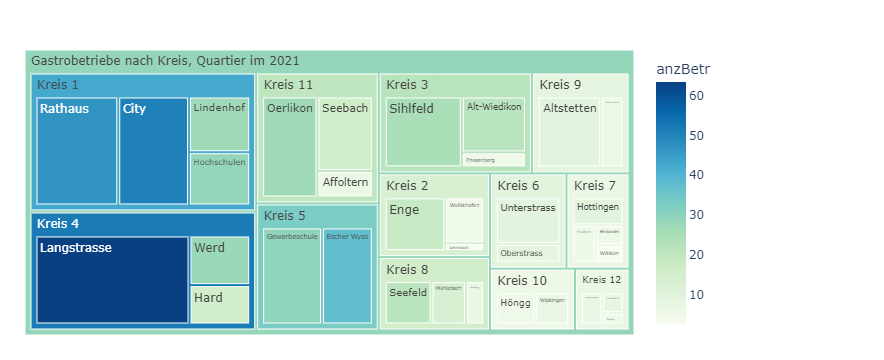

In [186]:
df = sum_gastrobetriebe_statz_quart_kreis.reset_index().query('Jahr == 2021')

fig = px.treemap(df, path=[px.Constant("Gastrobetriebe nach Kreis, Quartier im 2021"), 'KreisLang','QuarLang']
                 , values='anzBetr'
                 , color='anzBetr'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','Kreis 1':'gold', 'Kreis 2':'lightblue', 'Kreis 3':'olive' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='GnBu'
                #, color_continuous_midpoint=np.average(df['AnzPers'], weights=df['AnzPers']))           
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()


##### Heatmaps
------------------------------------------------------------

In [191]:
data2betested.dtypes

Jahr                 int64
Betriebsname        object
StrasseLang         object
HNr                 object
PLZ                  int64
Ort                 object
StatZoneSort         int64
StatZoneLang        object
QuarSort             int64
QuarLang            object
KreisSort            int64
KreisLang           object
Oeffnungszeit       object
Betriebsart         object
Betriebsstatus      object
XKoord             float64
YKoord             float64
NKoord             float64
EKoord             float64
AnzBetriebe          int64
AnzNachtcafe         int64
FirstLetter         object
SecondLetter        object
FirstTwoLetters     object
dtype: object

##### Heatmaps

In [200]:
sum_jahr_kreis = data2betested\
    .groupby(['KreisLang','Jahr','FirstLetter' ]) \
    .agg(anzBetr=('AnzBetriebe', 'sum') ) \
    .query('KreisLang != ""') \
    .sort_values('KreisLang', ascending=False)

sum_jahr_kreis.reset_index().head(2)

,KreisLang,Jahr,FirstLetter,anzBetr
0,Kreis 9,2021,n,1
1,Kreis 9,2015,H,3


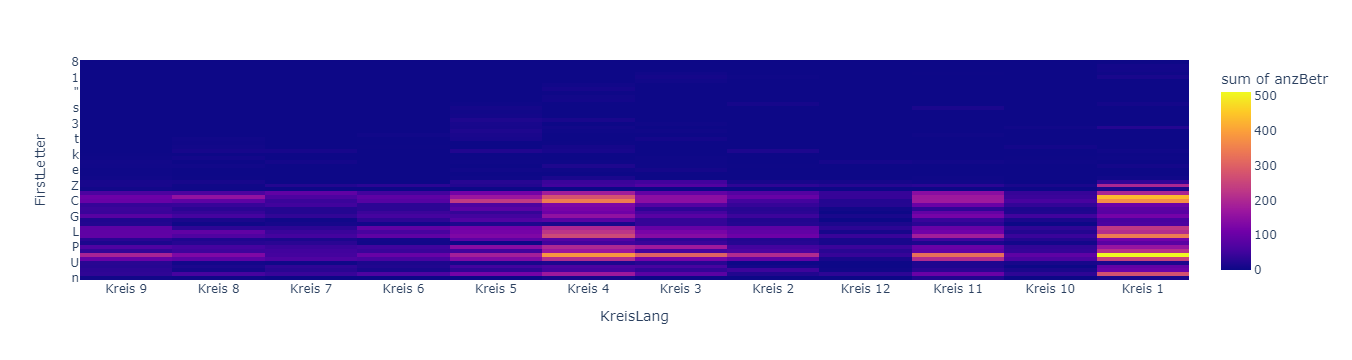

In [201]:
#df = px.data.tips()
df = sum_jahr_kreis.reset_index().query('KreisLang != ""')

fig1 = px.density_heatmap(df, x="KreisLang", y="FirstLetter", z="anzBetr", histfunc="sum")# , facet_row="KreisLang")#, facet_col="ListeKurzbez") #
fig1.show()

##### Scatter Gapminder

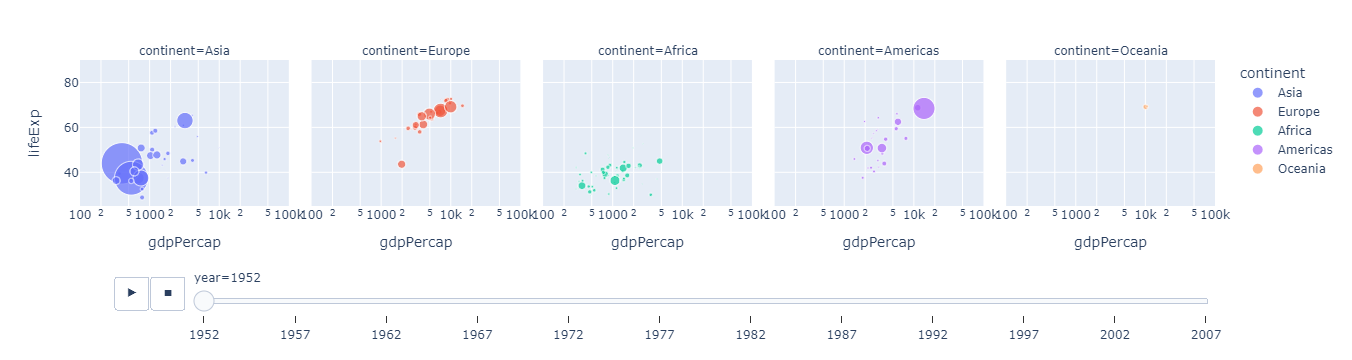

In [244]:
df = px.data.gapminder()
fig = px.scatter(df, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
           size="pop", color="continent", hover_name="country", facet_col="continent",
           log_x=True, size_max=45, range_x=[100,100000], range_y=[25,90])
fig.show()

In [246]:
px.data.gapminder().head(2)

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
0,Afghanistan,Asia,1952,29,8425333,779,AFG,4
1,Afghanistan,Asia,1957,30,9240934,821,AFG,4


In [269]:
sum_ListeKurzbez_geschlecht_altersgruppe = data2betested.groupby(['ListeKurzbez', 'Wahlkreis', 'Alters_grp', 'G'])[['AnzPers']].agg('sum')
sum_ListeKurzbez_geschlecht_altersgruppe.reset_index().head(1)

,ListeKurzbez,Wahlkreis,Alters_grp,G,AnzPers
0,AL,1 + 2,18-20,M,2


#### HIER STEHEN GEBLIEBEN
------------------------------------


